# Data Analysis Pipeline for SILAC dPex39 vs WT:

## Load packages and data

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

plt.rcParams["pdf.fonttype"] = 42
pd.set_option("display.max_columns", 10)

TEAL = "#C1D9D4"
DGREEN = "#3B592D"
GREEN = "#7E8C49"
ORANGE = "#D98452"
RED = "#BF4C41"

/opt/tljh/user/envs/autoprot/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)

Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.18'
  is ava

In [2]:
df = pp.read_csv("data/txt/proteinGroups.txt")
df = pp.cleaning(df)

print(f"The filtered data has {df.shape[0]} rows and {df.shape[1]} columns.")

4312 rows before filter operation.
4236 rows after filter operation.
The filtered data has 4236 rows and 100 columns.


In [3]:
df

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),...,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs,Taxonomy names
25,Q0045;Q0060;Q0070,Q0045,3;1;1,2;0;0,2;0;0,...,23661;393704;486327,NaN,NaN,-1;-1;-1,;;
26,Q0050,Q0050,4,4,3,...,147601;244290;416148;486327,NaN,NaN,-1,NaN
27,Q0055,Q0055,4,3,3,...,157992;311797;383663;486327,NaN,NaN,-1,NaN
28,Q0085,Q0085,1,1,1,...,485586,33;34,80;82,-1,NaN
29,Q0120,Q0120,4,4,1,...,69169;152776;248259;353575,NaN,NaN,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4307,YPR188C,YPR188C,4,4,4,...,41014;74681;237744;238955,NaN,NaN,-1,NaN
4308,YPR189W,YPR189W,34,34,34,...,7259;15068;19517;39822;40577;42155;61889;67202...,4510,155,-1,NaN
4309,YPR190C,YPR190C,15,15,15,...,93128;156410;188601;188951;191730;334209;35276...,4511;4512;4513,505;528;585,-1,NaN
4310,YPR191W,YPR191W,27,27,27,...,28419;43989;50652;58435;62383;62483;96855;1009...,NaN,NaN,-1,NaN


* SILAC labelling scheme:

- Rep 1 and 2: PEX39 KO is SILAC - Heavy; WT is SILAC - Light
- Rep 3 and 4: WT is SILAC - Heavy; PEX39 KO is SILAC - Light

# Merging with annotations:

In [4]:
sgd = pp.read_csv("data/SGD_Gene_Descriptions_March2022.tsv", sep="\t")

In [5]:
df.columns

Index(['Protein IDs', 'Majority protein IDs', 'Peptide counts (all)',
       'Peptide counts (razor+unique)', 'Peptide counts (unique)',
       'Fasta headers', 'Number of proteins', 'Peptides',
       'Razor + unique peptides', 'Unique peptides', 'Peptides 1',
       'Peptides 2', 'Peptides 3', 'Peptides 4', 'Razor + unique peptides 1',
       'Razor + unique peptides 2', 'Razor + unique peptides 3',
       'Razor + unique peptides 4', 'Unique peptides 1', 'Unique peptides 2',
       'Unique peptides 3', 'Unique peptides 4', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths',
       'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 4',
       'Fraction 5', 'Q-value', 'Score', 'Identification type 1',
       'Identification type 2', 'Identification type 3',
       'Identification type 4', 'Ratio H/L', 'Ratio H/L normalized',
       'Ratio H/L variability [%]', 

In [6]:
sgd.columns

Index(['Primary DBID', 'Systematic Name', 'Standard Name', 'Name',
       'Feature Type', 'Function Summary', 'Description', 'Gene Summary'],
      dtype='object')

In [7]:
df = df.merge(
    sgd, left_on="Majority protein IDs", right_on="Systematic Name", how="left"
)

## Creating Gene names column:

'Gene names' column which is entries from 'Standard Name' column, provided there are nan enrtries (with no gene names), in which case, entries from 'Systemic Name' column are copied. 

This column is used for annotation of the datasets.

In [8]:
df["Gene names"] = df["Standard Name"].fillna(df["Systematic Name"])

In [9]:
df["Gene names"].replace("YJR012C", "Pex39", inplace=True)

In [10]:
df["Gene names"] = df["Gene names"].str.title()

# Selecting cols:

## Label-switch:

- Rep 1 and 2: PEX39 KO is SILAC - Heavy; WT is SILAC - Light
- Rep 3 and 4: WT is SILAC - Heavy; PEX39 KO is SILAC - Light

Since the ratios are calculated H/L, we reverse ratios of Rep 3 and Rep 4.

In [11]:
l = df.filter(regex="^Ratio H/L normalized 3|^Ratio H/L normalized 4").columns

In [12]:
# invert the ratios to L/H
df[l] = df[l].apply(lambda x: 1 / x, 1)

## Inspection of channel intensities:

In [13]:
df, log_int_cols = pp.log(
    df,
    cols=df.filter(regex="Intensity (H|L) ").columns.to_list(),
    base=2,
    return_cols=True,
)

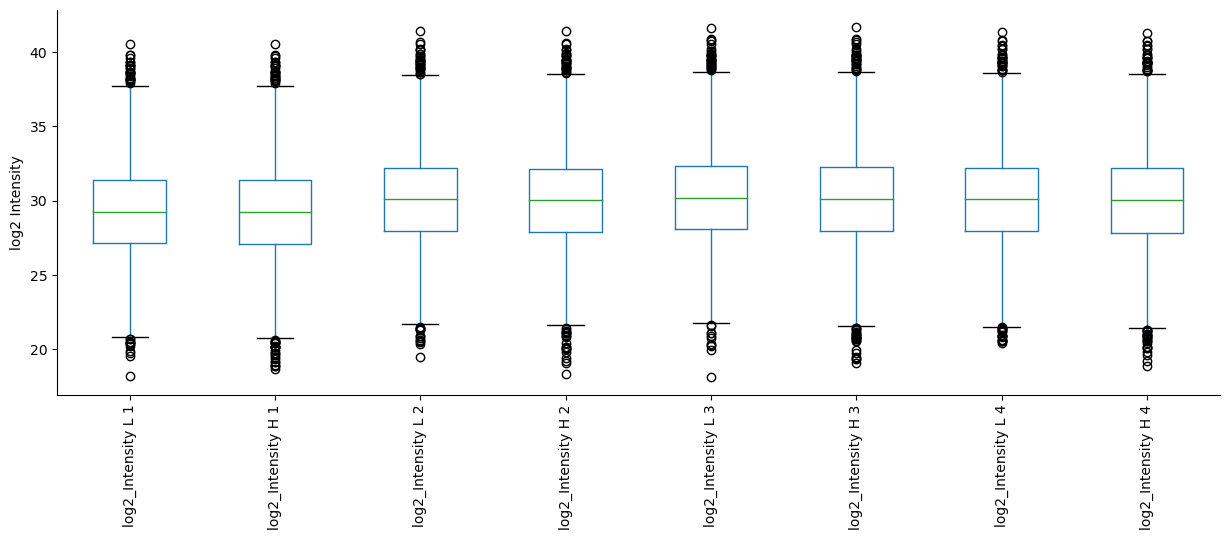

In [14]:
fig = vis.boxplot(
    df,
    reps=log_int_cols,
    labels=[x for x in log_int_cols],
    ret_fig=True,
    ylabel="log2 Intensity",
)
ax = fig.get_axes()[0]
ax.tick_params(axis="x", rotation=90)

## Intensity bar plot: Pex39
PEx39 was only quantifies in the last replicate 4.

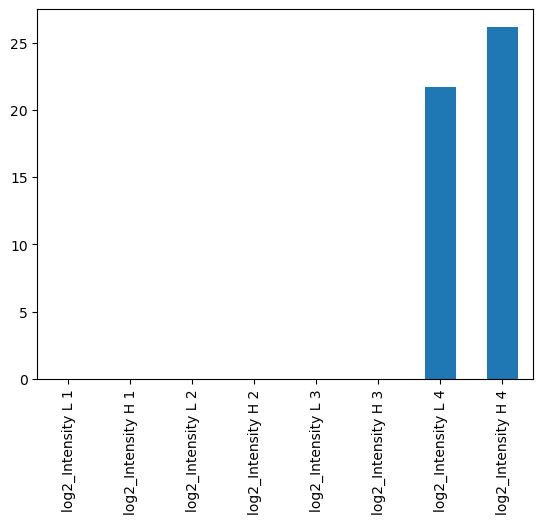

In [15]:
df[df["Majority protein IDs"] == "YJR012C"][log_int_cols].mean().plot(kind="bar")
plt.show()

# Analysis: Ratio H/L normalized:

In [16]:
df.filter(regex="^Ratio H/L normalized ")

,Ratio H/L normalized 1,Ratio H/L normalized 2,Ratio H/L normalized 3,Ratio H/L normalized 4
0,0.77048,0.83642,1.250203,1.209161
1,1.06850,0.88973,0.797067,0.899766
2,NaN,1.22130,1.291673,0.826993
3,0.96534,1.02380,0.951294,0.879507
4,0.89256,0.82931,1.808645,1.514165
...,...,...,...,...
4231,0.75477,0.97797,0.759244,1.346167
4232,1.02460,1.01920,0.955932,0.962371
4233,1.00230,1.00230,0.929800,0.986680
4234,0.89179,0.89243,1.037215,1.034800


In [17]:
ratioCols = list(df.filter(regex="^Ratio H/L normalized ").columns)

Replacing 0 values with NaN:

In [18]:
df[ratioCols] = df[ratioCols].replace(0, np.nan)

## log2 transformation:

In [19]:
df, log_ratio_cols = pp.log(df, ratioCols, base=2, return_cols=True)

In [20]:
log_ratio_cols

['log2_Ratio H/L normalized 1',
 'log2_Ratio H/L normalized 2',
 'log2_Ratio H/L normalized 3',
 'log2_Ratio H/L normalized 4']

In [21]:
df = pp.remove_non_quant(df, log_ratio_cols)

4236 rows before filter operation.
4227 rows after filter operation.


## PCA analysis of ratios:

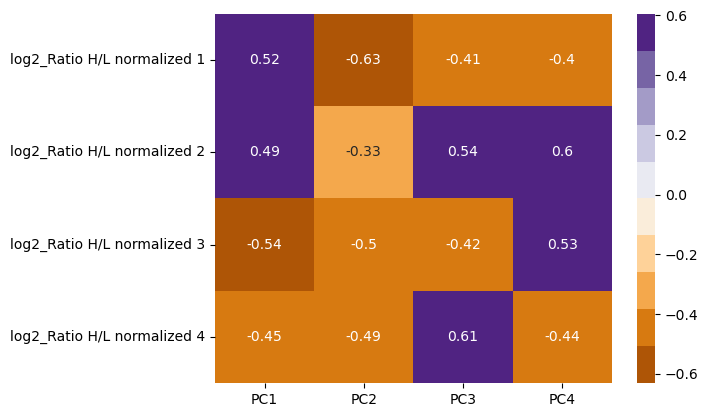

In [22]:
norm_int = df[log_ratio_cols]
pca = ana.AutoPCA(
    norm_int, rlabels=norm_int.index, clabels=[x for x in norm_int.columns.to_list()]
)
pca.corr_comp(annot=True)

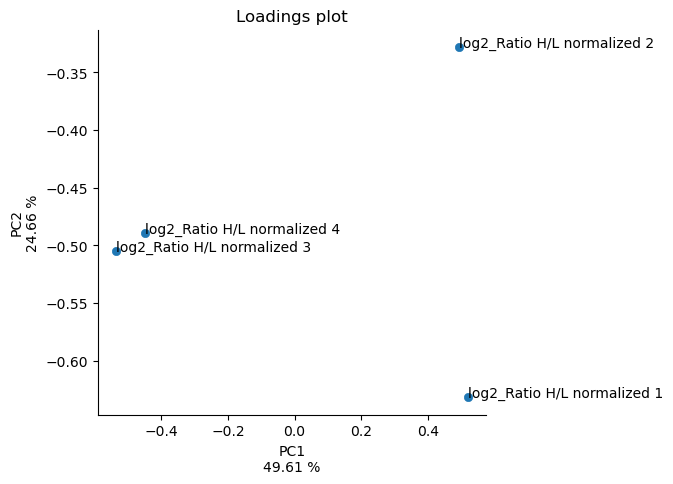

In [23]:
pca.loading_plot(pc1=1, pc2=2, labeling=True)

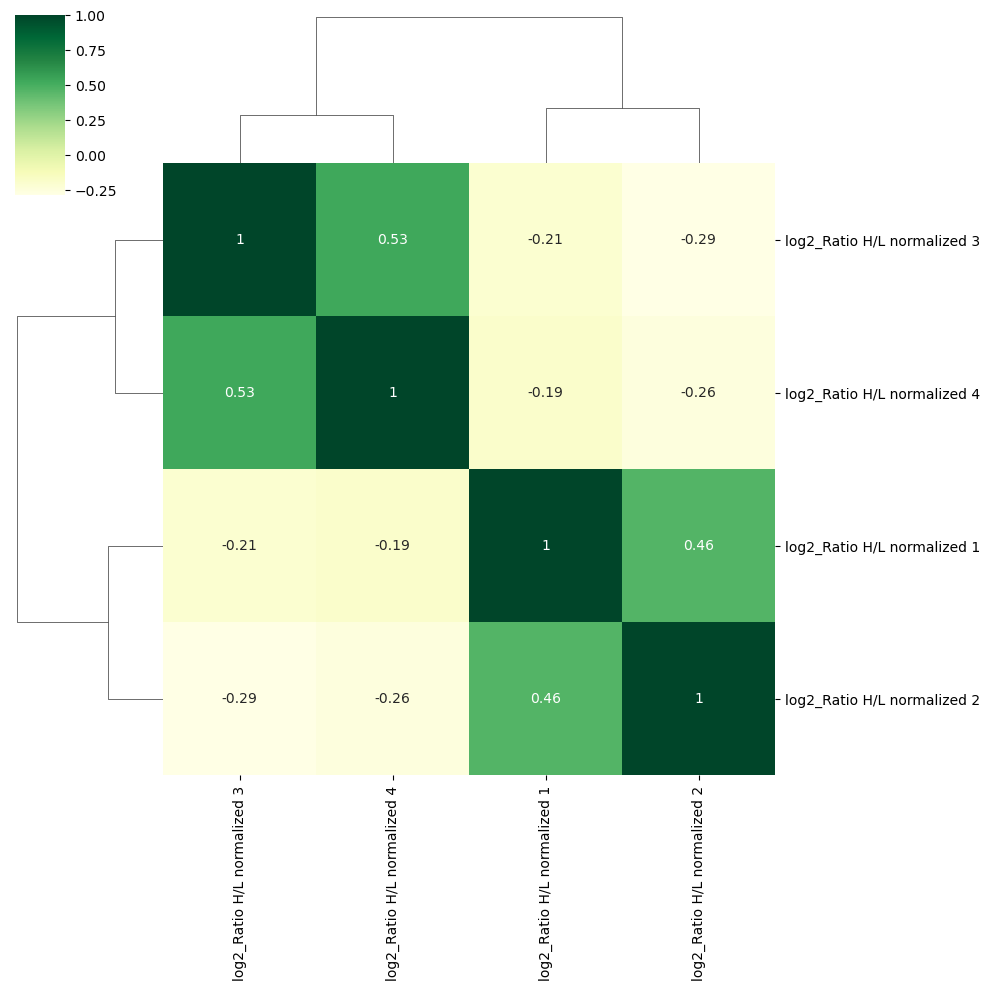

In [24]:
vis.corr_map(df, log_ratio_cols, cluster=True, annot=True)

## Ratio-intensity plots:

* Pex7 is blue
* Pex39 is black

/opt/tljh/user/envs/autoprot/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


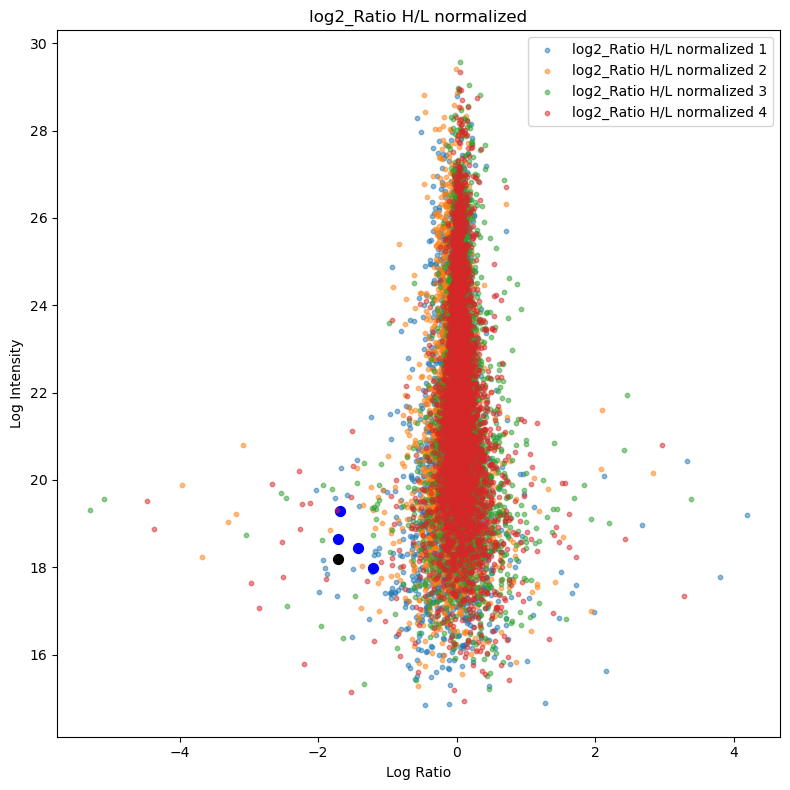

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, this_ax = plt.subplots(
    nrows=1, ncols=1, sharex="all", sharey="all", figsize=(8, 8)
)
int_cols = df.filter(regex="Intensity [^H|L]").columns.to_list()

for idx, col in enumerate(log_ratio_cols):
    # the column number goes from 0 to 4
    c = idx // 4
    # normalised values are plotted on top of the non-normalised values for comparison
    this_ax.scatter(df[col], np.log(df[int_cols[idx]]), label=col, alpha=0.5, s=10)
    temp = df[df["Majority protein IDs"] == "YDR142C"]
    this_ax.scatter(
        temp[col],
        np.log(temp[int_cols[idx]]),
        alpha=1,
        color="blue",
        s=50,
        linewidths=1,
    )

    temp = df[df["Majority protein IDs"] == "YJR012C"]
    this_ax.scatter(
        temp[col],
        np.log(temp[int_cols[idx]]),
        alpha=1,
        color="black",
        s=50,
        linewidths=1,
    )

    this_ax.set_xlabel("Log Ratio")
    this_ax.set_ylabel("Log Intensity")
    this_ax.set_title(col[:-2])
    # add a legend for colour scheme
    this_ax.legend()
plt.tight_layout()

# Data imputation

Imputation of Pex39 ratios in Rep 1, 2 and 3 drawing values from Rep 4 with a deviation of +/- 0.05.

Since 'YJR012C' is identified in only a single replicate, but depelted in dPex39/WT, means it has to be imputed singly to have the similar ratio values in the other replicates and represent it on the plot.

In [26]:
for col in df.loc[df["Majority protein IDs"] == "YJR012C", log_ratio_cols]:
    existing_value = -1.715762
    min_value = existing_value - 0.05
    max_value = existing_value + 0.05
    step = 0.1
    num_values = 11  # Number of values to generate
    imputed_values = np.random.uniform(min_value, max_value, num_values)

    df.loc[df["Majority protein IDs"] == "YJR012C", col] = df.loc[
        df["Majority protein IDs"] == "YJR012C", col
    ].fillna(np.random.choice(imputed_values))

In [27]:
df.loc[df["Majority protein IDs"] == "YJR012C", log_ratio_cols]

,log2_Ratio H/L normalized 1,log2_Ratio H/L normalized 2,log2_Ratio H/L normalized 3,log2_Ratio H/L normalized 4
2201,-1.736672,-1.711716,-1.696467,-1.715762


In [28]:
df[log_ratio_cols].count()

log2_Ratio H/L normalized 1    4045
log2_Ratio H/L normalized 2    4112
log2_Ratio H/L normalized 3    4082
log2_Ratio H/L normalized 4    4103
dtype: int64

## Filtering data with valid values in at least 3 of 4 reps:

In [29]:
df1 = pp.filter_vv(df, [log_ratio_cols], n=3, valid_values=True)

4227 rows before filter operation.
4072 rows after filter operation.


True

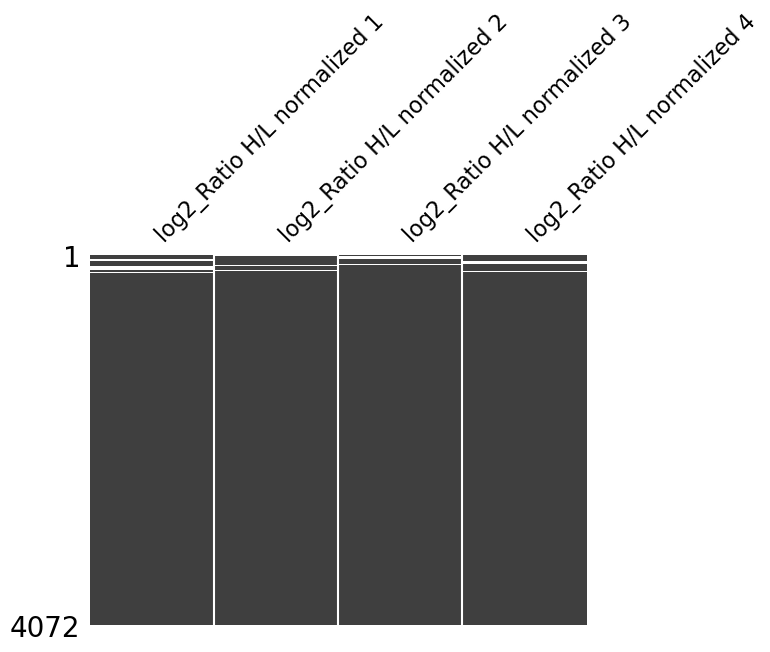

In [30]:
ana.miss_analysis(df1, log_ratio_cols, text=False, vis=False, extra_vis=True)

## Imputing the missing value using sequential imputation:

In [31]:
df1 = pp.imp_seq(df1, log_ratio_cols, print_r=False)

In [32]:
ratio_cols = df1.filter(regex="_imputed").columns.to_list()

In [33]:
ratio_cols

['log2_Ratio H L normalized 1_imputed',
 'log2_Ratio H L normalized 2_imputed',
 'log2_Ratio H L normalized 3_imputed',
 'log2_Ratio H L normalized 4_imputed']

## Normalization using cyclic-loess normalization:

In [34]:
df1 = pp.cyclic_loess(df1, ratio_cols)

In [35]:
df1.filter(regex="_normalized").columns.to_list()

['log2_Ratio.H.L.normalized.1_imputed_normalized',
 'log2_Ratio.H.L.normalized.2_imputed_normalized',
 'log2_Ratio.H.L.normalized.3_imputed_normalized',
 'log2_Ratio.H.L.normalized.4_imputed_normalized']

In [36]:
ratio_cols = df1.filter(regex="_normalized").columns.to_list()

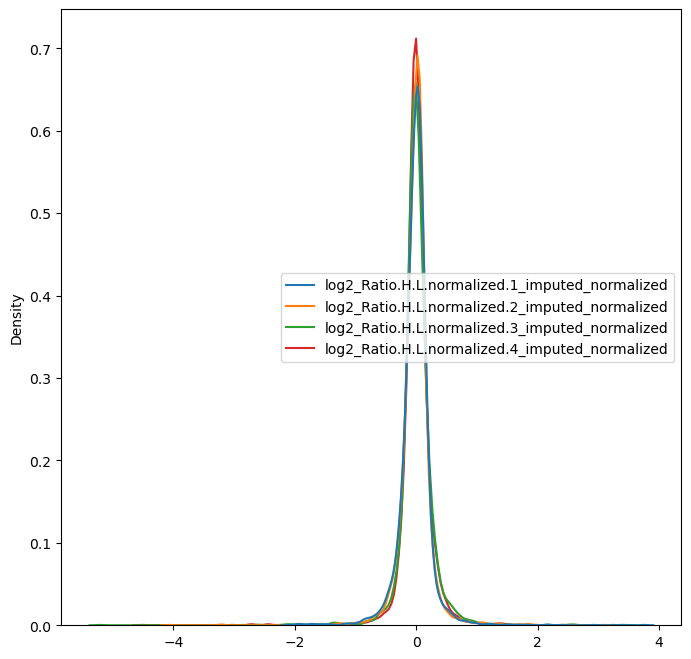

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharex=True)
sns.kdeplot(data=df1[ratio_cols], ax=ax)
plt.show()

# LIMMA ANALYSIS


In [38]:
condition_name = "_dYJR012C/WT"

In [39]:
df_limma = ana.limma(df1, [ratio_cols], cond=condition_name)

LIMMA: Assuming a one sample test


# Volcano plots

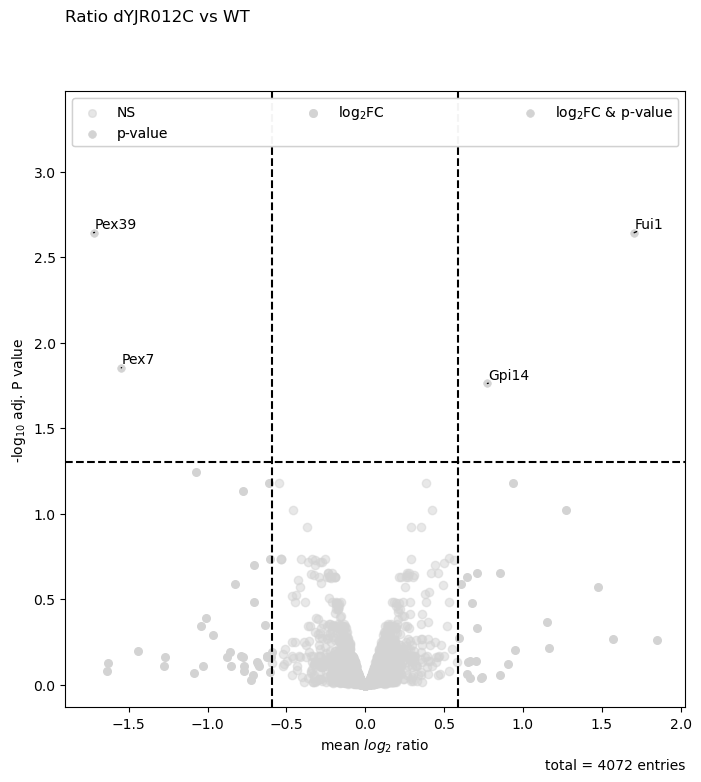

In [40]:
fig = vis.volcano(
    df_limma,
    title="Ratio dYJR012C vs WT",
    log_fc_colname="logFC_dYJR012C/WT",
    p_colname="adj.P.Val_dYJR012C/WT",
    p_thresh=0.05,
    log_fc_thresh=0.59,
    annotate_colname="Gene names",
    annotate_density=100,
    kwargs_both_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        "linewidths": 0.5,  # set highlight linewidths to 0.5
    },
    kwargs_log_fc_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
    },
    kwargs_p_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        # set highlight edge colors to black
        "linewidths": 0.5,  # set highlight linewidths to 0.5
    },
)

for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio ")
    ax.set_ylabel(r"-log$_{10}$ adj. P value")

List of all known peroxisomal proteins based on 'Peroxi-Ome' dataset (Yifrach et al., 2022)

In [41]:
poi_po = [
    "YLR027C",
    "YPR128C",
    "YML042W",
    "YCR005C",
    "YDR256C",
    "YIR031C",
    "YOR180C",
    "YLR284C",
    "YER015W",
    "YBR041W",
    "YKR009C",
    "YDL022W",
    "YGR154C",
    "YNL009W",
    "YMR204C",
    "YMR163C",
    "YOR084W",
    "YIR034C",
    "YDR234W",
    "YDL078C",
    "YNL117W",
    "YGL067W",
    "YLR151C",
    "YBR222C",
    "YKL197C",
    "YJL210W",
    "YDR329C",
    "YGR133W",
    "YDR244W",
    "YNL329C",
    "YDR142C",
    "YGR077C",
    "YDR265W",
    "YOL147C",
    "YMR026C",
    "YLR191W",
    "YGL153W",
    "YOL044W",
    "YNL214W",
    "YHR160C",
    "YDL065C",
    "YGR239C",
    "YAL055W",
    "YPL112C",
    "YOR193W",
    "YHR150W",
    "YDR479C",
    "YLR324W",
    "YGR004W",
    "YBR168W",
    "YCL056C",
    "YGR168C",
    "YGL037C",
    "YIL160C",
    "YGL205W",
    "YPL147W",
    "YKL188C",
    "YEL020C",
    "YNL202W",
    "YGL184C",
    "YJR019C",
    "YMR304W",
    "YBL039W-B",
    "YIL089W",
    "YLR389C",
    "YJL031C",
    "YMR018W",
    "YOL126C",
    "YER014W",
    "YDR255C",
    "YBR255W",
    "YJR111C",
]

In [42]:
# Created a new column 'Known/new POX protein acc. to Eyifrach' in df_limma
df_limma["Known/new POX protein acc. to Eyifrach"] = ""

# Iterated through the 'poi_po' list and check for matches in the 'Systematic Name' column
for poi in poi_po:
    df_limma.loc[
        df_limma["Systematic Name"] == poi, "Known/new POX protein acc. to Eyifrach"
    ] = "Known"

In [43]:
poi = ["Gpd1", "Pnc1", "Pot1"]

In [44]:
df_limma[df_limma["Gene names"].isin(poi)]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),...,t_dYJR012C/WT,P.Value_dYJR012C/WT,adj.P.Val_dYJR012C/WT,B_dYJR012C/WT,Known/new POX protein acc. to Eyifrach
index,,,,,,,,,,,
461,YDL022W,YDL022W,14,14,13,...,2.393225,0.062849,0.675698,-4.351425,Known
1280,YGL037C,YGL037C,9,9,9,...,2.344814,0.066707,0.675698,-4.413349,Known
1947,YIL160C,YIL160C,25,25,25,...,-0.326920,0.757149,0.974661,-6.509560,Known


### With adj. p-values and highlights:

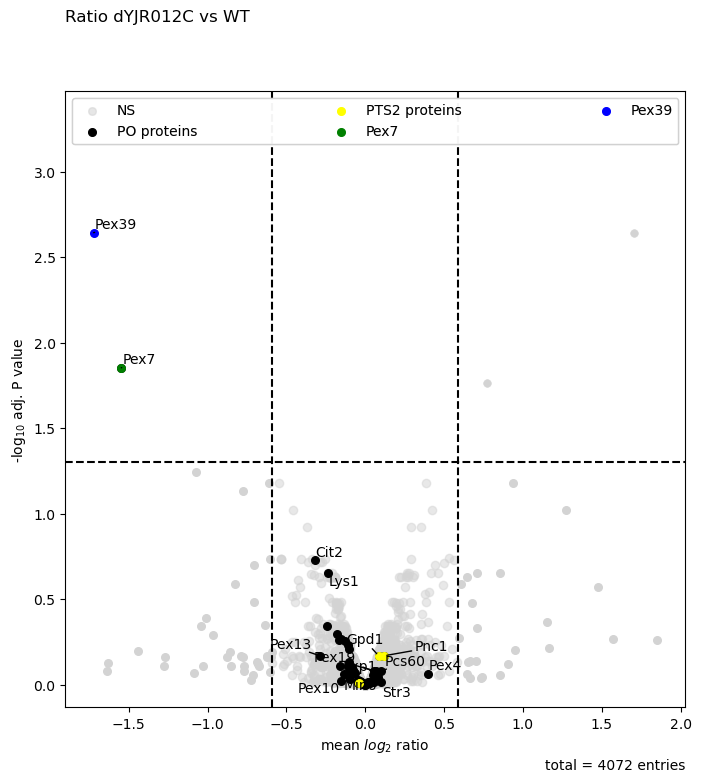

In [45]:
default_highlight_kwargs = {
    "marker": "o",  # set highlight shape to circle
    "s": 30,  # set highlight size to 100
    "alpha": 1,  # set highlight alpha to 0.8
}

fig = vis.volcano(
    df_limma,
    title="Ratio dYJR012C vs WT",
    log_fc_colname="logFC_dYJR012C/WT",
    p_colname="adj.P.Val_dYJR012C/WT",
    p_thresh=0.05,
    log_fc_thresh=0.59,
    annotate_colname="Gene names",
    annotate_density=100,
    highlight=[
        df_limma[df_limma["Systematic Name"].isin(poi_po)].index,
        df_limma[df_limma["Gene names"].isin(poi)].index,
        df_limma.loc[df_limma["Gene names"] == "Pex7"].index,
        df_limma.loc[df_limma["Gene names"] == "Pex39"].index,
    ],
    annotate="highlight",
    kwargs_highlight=[
        default_highlight_kwargs
        | {
            "color": "black",  # set highlight color to red
            "label": "PO proteins",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "yellow",  # set highlight color to red
            "label": "PTS2 proteins",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "green",  # set highlight color to red
            "label": "Pex7",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "blue",  # set highlight color to red
            "label": "Pex39",  # set highlight label
        },
    ],
    kwargs_both_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        #      'edgecolors': '#58b3e8',    # set highlight edge colors to black
        "linewidths": 0.5,  # set highlight linewidths to 0.5
        "label": None,  # set highlight label
    },
    kwargs_log_fc_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        "label": None,  # set highlight label
    },
    kwargs_p_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        # set highlight edge colors to black
        "linewidths": 0.5,  # set highlight linewidths to 0.5
        "label": None,  # set highlight label
    },
)

for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio ")
    ax.set_ylabel(r"-log$_{10}$ adj. P value")

## With top enriched/depleted based on log2 FC:

In [46]:
# Sort the DataFrame by the column in descending order
df_limma_top20 = df_limma.sort_values(by="logFC_dYJR012C/WT", ascending=False)

In [47]:
poi1 = df_limma_top20.head(20)["Gene names"].to_list()

In [48]:
# Sort the DataFrame by the column in descending order
df_limma_down20 = df_limma.sort_values(by="logFC_dYJR012C/WT", ascending=True)

In [49]:
poi2 = df_limma_down20.head(20)["Gene names"].to_list()

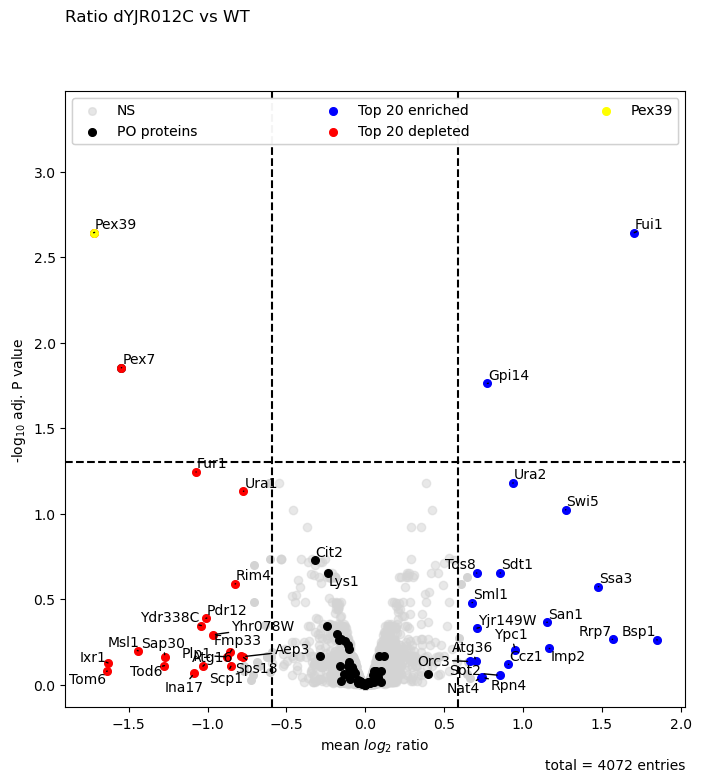

In [50]:
fig = vis.volcano(
    df_limma,
    title="Ratio dYJR012C vs WT",
    log_fc_colname="logFC_dYJR012C/WT",
    p_colname="adj.P.Val_dYJR012C/WT",
    p_thresh=0.05,
    log_fc_thresh=0.59,
    # show_legend = False,
    annotate_colname="Gene names",
    annotate_density=200,
    highlight=[
        df_limma[df_limma["Systematic Name"].isin(poi_po)].index,
        df_limma[df_limma["Gene names"].isin(poi1)].index,
        df_limma[df_limma["Gene names"].isin(poi2)].index,
        df_limma.loc[df_limma["Gene names"] == "Pex39"].index,
    ],
    annotate="highlight",
    kwargs_highlight=[
        default_highlight_kwargs
        | {
            "color": "black",  # set highlight color to red
            "label": "PO proteins",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "blue",  # set highlight color to red
            "label": "Top 20 enriched",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "red",  # set highlight color to red
            "label": "Top 20 depleted",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "yellow",  # set highlight color to red
            "label": "Pex39",  # set highlight label
        },
    ],
    kwargs_both_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        "linewidths": 0.5,  # set highlight linewidths to 0.5
        "label": None,  # set highlight label
    },
    kwargs_log_fc_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        "label": None,  # set highlight label
    },
    kwargs_p_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        # set highlight edge colors to black
        "linewidths": 0.5,  # set highlight linewidths to 0.5
        "label": None,  # set highlight label
    },
)

for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio ")
    ax.set_ylabel(r"-log$_{10}$ adj. P value")

# Data merge to main dataframe:
To retain all entries before valid value filter and imputation:

In [51]:
merge1 = pd.merge(df, df_limma, how="left", on="id", suffixes=("", "_y"))
merge1.drop(merge1.filter(regex="_y$").columns.tolist(), axis=1, inplace=True)

In [52]:
merge1

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),...,t_dYJR012C/WT,P.Value_dYJR012C/WT,adj.P.Val_dYJR012C/WT,B_dYJR012C/WT,Known/new POX protein acc. to Eyifrach
0,Q0045;Q0060;Q0070,Q0045,3;1;1,2;0;0,2;0;0,...,-0.064918,0.950789,0.994209,-6.569431,
1,Q0050,Q0050,4,4,3,...,-1.586124,0.174384,0.805823,-5.378302,
2,Q0055,Q0055,4,3,3,...,1.146721,0.304078,0.901492,-5.886021,
3,Q0085,Q0085,1,1,1,...,-1.204924,0.282858,0.887392,-5.823309,
4,Q0120,Q0120,4,4,1,...,1.778923,0.136203,0.776655,-5.137989,
...,...,...,...,...,...,...,...,...,...,...,...
4222,YPR188C,YPR188C,4,4,4,...,-0.734238,0.496211,0.958636,-6.270440,
4223,YPR189W,YPR189W,34,34,34,...,-0.276430,0.793429,0.977162,-6.527195,
4224,YPR190C,YPR190C,15,15,15,...,-0.604762,0.572084,0.961043,-6.363953,
4225,YPR191W,YPR191W,27,27,27,...,-1.340431,0.238547,0.864202,-5.671194,


# Data export:

In [53]:
merge1.to_csv(
    "results/Results_SILAC_dPex39_vs_WT_complete_hd_v01.txt",
    index=False,
    sep="\t",
)

In [54]:
merge1.to_excel("results/Results_SILAC_dPex39_vs_WT_complete_hd_v01.xlsx", index=False)